In [8]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow import Zero, One, I, X, Y, Z, SummedOp, PauliOp
from qiskit.circuit import Parameter, ParameterVector
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

In [9]:
def compute_H(eps, t, delta, num_sites):

    H = 0
    for i in range(num_sites):
        H += eps / 2 * ((I ^ num_sites) - ((I ^ (num_sites - i - 1)) ^ Z ^ (I ^ i)))
        if i < num_sites - 1:
            H += (t + delta) / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
            H += (t - delta) / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))

    return H

# Example computation. This Hamiltonian is the same model we cover in the paper and will persist through the notebook.
num_sites = 3

# Parameterized hopping strengths
eps_param = Parameter("ε")
t_param = Parameter("t")
delta_param = Parameter("Δ")
H_param = compute_H(eps_param, t_param, delta_param, num_sites)

# Select specific tau and tau_d values
H = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliSumOp(SparsePauliOp(['III', 'IIZ'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.5), PauliOp(Pauli('IXX'), coeff=1.5), PauliOp(Pauli('IYY'), coeff=-0.5), PauliSumOp(SparsePauliOp(['III', 'IZI'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.5), PauliOp(Pauli('XXI'), coeff=1.5), PauliOp(Pauli('YYI'), coeff=-0.5), PauliSumOp(SparsePauliOp(['III', 'ZII'],
              coeffs=[ 1.+0.j, -1.+0.j]), coeff=0.5)], coeff=1.0, abelian=False)

### Import observables

In [10]:
#Number operator
from operators import n_op, corr_op, corr_dagger_op

cc_nb_is = corr_op(num_sites,0,1)
cc_dagger_nb_is = corr_dagger_op(num_sites,0,1)
from functions import exact_time_evolution, exact_time_evolution_energy, exact_time_evolution_density

### Classical simulation: Number operator

In [11]:
#Parameters for simulation
time_max = 4
times = np.linspace(0, time_max * np.pi, 500)
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]
# Plot the time evolution
H_1 = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1})
H_2 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2})
H_3 = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: -1})

initial_state_1 = One ^ Zero ^ Zero
n_H1_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state_1, times, num_sites)
n_H2_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state_1, times, num_sites)
n_H3_evo_matrix_state_1, n_var_matrix = exact_time_evolution(H_3, n_is, initial_state_1, times, num_sites)

initial_state_2 = One ^ One ^ One #(1 / np.sqrt(3))*(One ^ Zero ^ Zero) + (1 / np.sqrt(3))*(Zero ^ One ^ Zero) + (1 / np.sqrt(2))*(Zero ^ Zero ^ One)
n_H1_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_1, n_is, initial_state_2, times, num_sites)
n_H2_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_2, n_is, initial_state_2, times, num_sites)
n_H3_evo_matrix_state_2, n_var_matrix = exact_time_evolution(H_3, n_is, initial_state_2, times, num_sites)

100%|██████████| 500/500 [00:16<00:00, 30.40it/s]


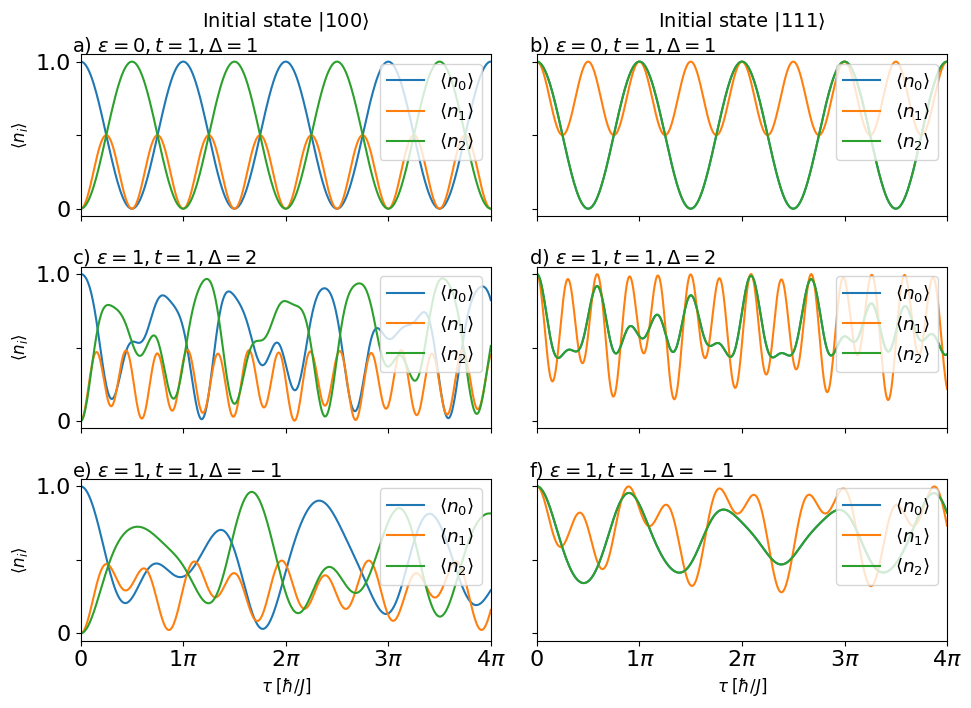

In [ ]:
num_op_labels = [rf"$\langle n_{i} \rangle$" for i in range(num_sites)]

xticks = np.linspace(0, time_max * np.pi, time_max + 1)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(time_max + 1)]
yticks = [0, 0.5, 1.0]
ytick_labels = ['0', '', '1.0']

# --- Create 3x2 Subplot Grid ---
fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey=True) # Adjusted for 3 rows

# --- Column Titles (set on the top-most plots of each column) ---
axs[0, 0].set_title(r"Initial state $|100\rangle$", fontsize=14, pad=20)
axs[0, 1].set_title(r"Initial state $|111\rangle$", fontsize=14, pad=20)
#axs[0, 1].set_title(r"Initial state $1/\sqrt{3}\left(|100\rangle + |010\rangle + |001\rangle \right)$", fontsize=14, pad=20)

# --- Plotting Data ---
# Column 1: initial_state_1
axs[0, 0].plot(times, n_H1_evo_matrix_state_1) # H1 params
axs[1, 0].plot(times, n_H2_evo_matrix_state_1) # H2 params
axs[2, 0].plot(times, n_H3_evo_matrix_state_1) # H3 params

# Column 2: initial_state_2
axs[0, 1].plot(times, n_H1_evo_matrix_state_2) # H1 params
axs[1, 1].plot(times, n_H2_evo_matrix_state_2) # H2 params
axs[2, 1].plot(times, n_H3_evo_matrix_state_2) # H3 params


# --- Row & Corner Labels ---
corner_labels = [
    [r'a) $\varepsilon=0, t=1, \Delta=1$', r'b) $\varepsilon=0, t=1, \Delta=1$'],      # Row for H1
    [r'c) $\varepsilon=1, t=1, \Delta=2$', r'd) $\varepsilon=1, t=1, \Delta=2$'],      # Row for H2
    [r'e) $\varepsilon=1, t=1, \Delta=-1$', r'f) $\varepsilon=1, t=1, \Delta=-1$']     # Row for H3
]
# tau_labels is defined in user's code but not used, so kept commented.
# tau_labels = [r"$t=0.5$", r"$t=1.0$"]

for r in range(3): # Iterate through 3 rows
    axs[r, 0].set_ylabel(rf"$\langle n_i \rangle$", fontsize=12)
    if r == 2: # X-labels only on the bottom row
        for c_xlabel in range(2):
            axs[r, c_xlabel].set_xlabel(rf"$\tau \; [\hbar/J]$", fontsize=12)

    for c in range(2): # Iterate through 2 columns
        axs[r, c].text(-0.02, 1.12, corner_labels[r][c], transform=axs[r, c].transAxes,
                       fontsize=14, va='top', ha='left')
        axs[r, c].legend(num_op_labels, loc='upper right', fontsize='small')
        
# --- General Formatting for all Subplots ---
for ax in axs.flat:
    ax.set_xlim(0, time_max * np.pi)
    ax.set_ylim(-0.05, 1.05) # Matches yticks range
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

# Set tick labels only on the outer plots
for ax_idx, ax in enumerate(axs[2, :]):  # Bottom row
    ax.set_xticklabels(xtick_labels)
for ax_idx, ax in enumerate(axs[:, 0]):  # Left column
    ax.set_yticklabels(ytick_labels)

# --- Customize Y-Tick Length ---
default_tick_length = plt.rcParams['ytick.major.size']
for ax in axs[:, 0]: # Loop through axes in the left column
    y_ticks_list = ax.yaxis.get_major_ticks()
    for tick in y_ticks_list:
        if np.isclose(tick.get_loc(), 0.6): # Check for the middle tick at 0.6
            tick.tick1line.set_markersize(default_tick_length / 2)
            tick.tick2line.set_markersize(default_tick_length / 2) # For ticks on both sides

# --- Final Figure Adjustments ---
# Individual subplot legends are used.
# If a single figure legend is preferred, uncomment and adjust:
# handles, _ = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, num_op_labels, loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=num_sites, frameon=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent title overlap
plt.savefig('figures/3-site-kitaev/site-prob-multi-100.pdf')

### Trotterization

In [ ]:
# Time evolution calculation using same parameters as the exact classical calculation
from functions import trotter_evolution
times = np.linspace(0, 8 * np.pi, 500)

# Number of trotter steps
H = H_param.bind_parameters({eps_param: 1, t_param: 1, delta_param: 2})

initial_state = One ^ Zero ^ Zero #(1 / np.sqrt(3))*(One ^ Zero ^ Zero) + (1 / np.sqrt(3))*(Zero ^ One ^ Zero) + (1 / np.sqrt(2))*(Zero ^ Zero ^ One)

trotter_steps_1 = 2
evo_matrix_trot_1 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_1)
# trotter_steps_2 = 5
# evo_matrix_trot_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_2)
trotter_steps_3 = 8
evo_matrix_trot_3 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_3)

n_evo_matrix_exact, n_var_matrix = exact_time_evolution(H, n_is, initial_state, times, num_sites)

100%|██████████| 500/500 [00:16<00:00, 29.75it/s]


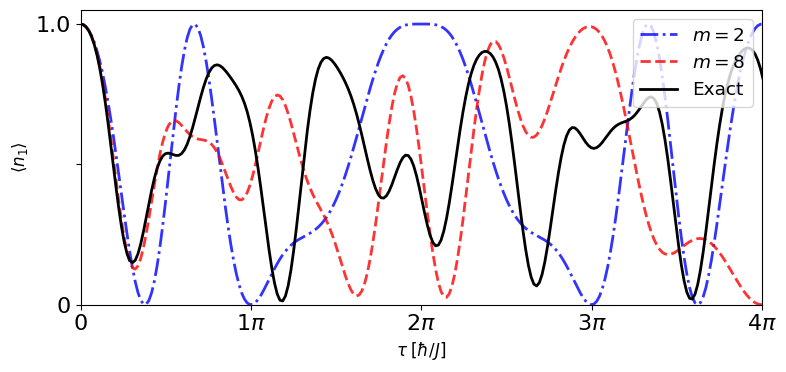

In [40]:
# Plot state dynamics over one particular site
site = 0

xticks = np.linspace(0, 4 * np.pi, 5)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(5)]
yticks = [0, 0.5, 1.0]
ytick_labels = ['0', '', '1.0']

plt.figure(figsize=(8, 4))
plt.plot(
    times,
    evo_matrix_trot_1[:, site],
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_1}$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_3[:, site],
    "r--",
    linewidth=2,
    label=rf"$m={trotter_steps_3}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
# plt.plot(
#     times,
#     evo_matrix_trot_3[:, site],
#     "g--",
#     linewidth=2,
#     label=rf"$m={trotter_steps_3}$",
#     markerfacecolor="green",
#     alpha=0.8,
# )
plt.plot(
    times, n_evo_matrix_exact[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel(rf"$\tau \; [\hbar/J]$", fontsize=12)
plt.ylabel(rf"$\langle n_{site+1} \rangle$", fontsize=12)
plt.ylim([0.0, 1.05])
plt.xlim([0, 4*np.pi])
plt.legend(loc='upper right', framealpha=0.8, fontsize='small')
plt.tight_layout()
plt.xticks(xticks, xtick_labels) 
plt.yticks(yticks, ytick_labels)
plt.savefig('figures/3-site-kitaev/site1_100_trotterization.pdf')
plt.show()

In [37]:
# Number of trotter steps
trotter_steps_error_1 = 15
trotter_steps_error_2 = 25
trotter_steps_error_3 = 50
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_error_1 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_1)
evo_matrix_trot_error_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_2)
evo_matrix_trot_error_3 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error_3)

100%|██████████| 500/500 [10:22<00:00,  1.25s/it]


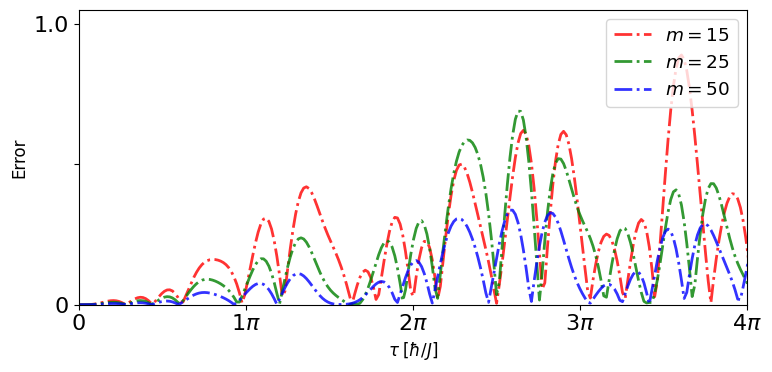

In [39]:
# Plot state dynamics over one particular site
site = 0

plt.figure(figsize=(8, 4))
plt.plot(
    times,
    np.abs(n_evo_matrix_exact[:, site]-evo_matrix_trot_error_1[:, site]),
    "r-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_1}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times,
    np.abs(n_evo_matrix_exact[:, site]-evo_matrix_trot_error_2[:, site]),
    "g-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_2}$",
    markerfacecolor="seagreen",
    alpha=0.8,
)
plt.plot(
    times,
    np.abs(n_evo_matrix_exact[:, site]-evo_matrix_trot_error_3[:, site]),
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_error_3}$",
    markerfacecolor="darkorange",
    alpha=0.8,
)

plt.xlabel(rf"$\tau \; [\hbar/J]$", fontsize=12)
plt.ylabel(rf"Error", fontsize=12)
plt.ylim([0.0, 1.05])
plt.xlim([0, 4*np.pi])
plt.legend(loc='upper right', framealpha=0.8, fontsize='small')
plt.tight_layout()
plt.xticks(xticks, xtick_labels) 
plt.yticks(yticks, ytick_labels)
plt.tight_layout()
plt.savefig('figures/3-site-kitaev/trotter-error.pdf')

plt.show()

### Generate circuit diagram

In [ ]:
def compute_H_secondquant_normal(eps, t, delta, num_sites):
    second_quant_H = 0
    # i = 0
    # second_quant_H += eps * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)))
    # econd_quant_H += t * (FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i + 1)))
    # second_quant_H += t * (FermionicOp("+_{}".format(i+1)) @ FermionicOp("-_{}".format(i)))
    # second_quant_H += delta * (FermionicOp("+_{}".format(i)) @ FermionicOp("+_{}".format(i + 1)))
    # second_quant_H += delta * (FermionicOp("-_{}".format(i + 1)) @ FermionicOp("-_{}".format(i)))
    # i = 1
    # second_quant_H += eps * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)))
    # econd_quant_H += t * (FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i + 1)))
    # second_quant_H += t * (FermionicOp("+_{}".format(i+1)) @ FermionicOp("-_{}".format(i)))
    # second_quant_H += delta * (FermionicOp("+_{}".format(i)) @ FermionicOp("+_{}".format(i + 1)))
    # second_quant_H += delta * (FermionicOp("-_{}".format(i + 1)) @ FermionicOp("-_{}".format(i)))
    # i = 
    # second_quant_H += eps * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)))
    # econd_quant_H += t * (FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i + 1)))
    # second_quant_H += t * (FermionicOp("+_{}".format(i+1)) @ FermionicOp("-_{}".format(i)))
    # second_quant_H += delta * (FermionicOp("+_{}".format(i)) @ FermionicOp("+_{}".format(i + 1)))
    # second_quant_H += delta * (FermionicOp("-_{}".format(i + 1)) @ FermionicOp("-_{}".format(i)))

    for i in range(num_sites-1):
        second_quant_H += eps * ( FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i)))
        if i <= num_sites-1:
            second_quant_H += delta * (FermionicOp("+_{}".format(i)) @ FermionicOp("+_{}".format(i + 1)))
            second_quant_H += delta * (FermionicOp("-_{}".format(i + 1)) @ FermionicOp("-_{}".format(i)))

            second_quant_H += t * (FermionicOp("+_{}".format(i)) @ FermionicOp("-_{}".format(i + 1)))
            second_quant_H += t * (FermionicOp("+_{}".format(i+1)) @ FermionicOp("-_{}".format(i)))


    second_quant_H += eps * ( FermionicOp("+_{}".format(num_sites-1)) @ FermionicOp("-_{}".format(num_sites-1)))
    # Transform to Pauli Operators
    jw_mapper = JordanWignerMapper
    pauli_H = JordanWignerMapper.map(jw_mapper, second_quant_H)

    return pauli_H


In [ ]:
def compute_H(eps, t, delta, num_sites):

    H = 0
    for i in range(num_sites):
        H += eps / 2 * ((I ^ num_sites) - ((I ^ (num_sites - i - 1)) ^ Z ^ (I ^ i)))
        if i < num_sites - 1:
            H += (t + delta) / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
            H += (t - delta) / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))

    return H

In [ ]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

#Parameterized hopping strengths
eps_param = Parameter("ε")
t_param = Parameter("t")
delta_param = Parameter("Δ")
H_param = compute_H(eps_param, t_param, delta_param, num_sites)
from functions import compute_U_trot

num_sites = 3
eps = 1
t = 1
delta = 2

H = compute_H(eps, t, delta, num_sites) #H_param.bind_parameters({eps_param: eps, t_param: t, delta_param: delta})

U1 = compute_U_trot(H, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/3-site-circuit.tex", "w") as f:
    f.write(latex_code)

NameError: name 'Parameter' is not defined